In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

torch.__version__

'2.2.2+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print( f"Using device: { device}")

Using device: cuda


## Data

In [3]:
weight = 0.4

bias = 0.1

start = 0
end = 1
step = 0.02

X = torch.arange( start, end, step, device=device).unsqueeze( dim=1)
y = weight * X + bias

X[ :10], y[ :10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]], device='cuda:0'),
 tensor([[0.1000],
         [0.1080],
         [0.1160],
         [0.1240],
         [0.1320],
         [0.1400],
         [0.1480],
         [0.1560],
         [0.1640],
         [0.1720]], device='cuda:0'))

In [4]:
# Split data
train_split = int( 0.8 * len( X))

X_train, y_train = X[ :train_split], y[ :train_split]
X_test, y_test = X[ train_split:], y[ train_split:]

len( X_train), len( y_train), len( X_test), len( y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(
		train_data=X_train.cpu(),
		train_labels=y_train.cpu(),
		test_data=X_test.cpu(),
		test_labels=y_test.cpu(),
		predictions=None
):
	plt.figure( figsize=( 10, 7))

	plt.scatter( train_data, train_labels, c="b", s=4, label="Training Data")

	plt.scatter( test_data, test_labels, c="g", s=4, label="Testing Data")

	if predictions is not None:
		plt.scatter( test_data, predictions, c="r", s=4, label="Predictions")

	plt.legend( prop={ "size": 14})

	plt.show()

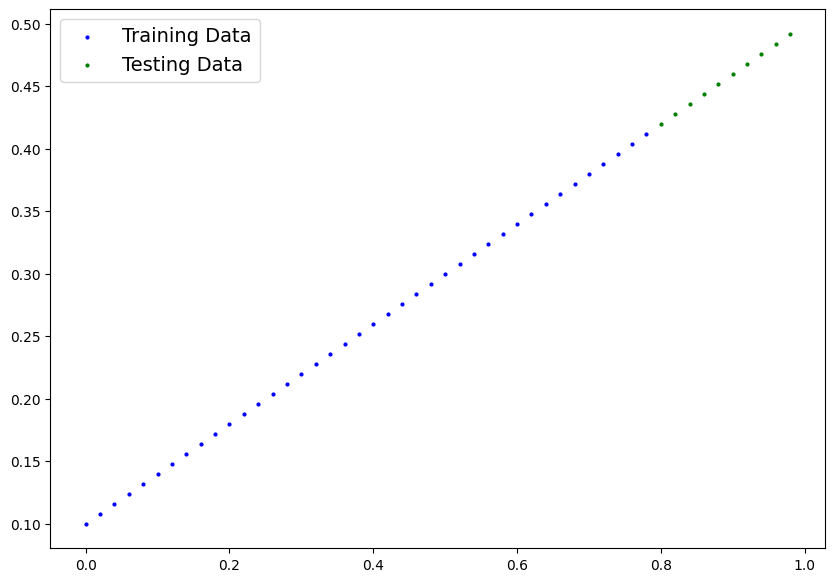

In [6]:
plot_predictions()

## Model

In [7]:
class LinearRegressionModel( nn.Module):
	def __init__( self):
		super().__init__()

		# Use nn.Linear for creating the parameters

		self.linear_layer = nn.Linear( in_features=1, out_features=1)

	def forward( self, x: torch.Tensor) -> torch.Tensor:
		return self.linear_layer( x)
	
# Set the manual seed
torch.manual_seed( 42)

model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [8]:
# check the model current device
next( model_1.parameters()).device

device(type='cpu')

In [9]:
model_1.to( device)
next( model_1.parameters()).device

device(type='cuda', index=0)

## Training

In [10]:
# setup loss function
loss_fn = nn.L1Loss()

# setup optimizer
optimizer = torch.optim.SGD( params=model_1.parameters(), lr=0.01)

In [11]:
# training loop

torch.manual_seed( 42)

epochs = 200

for epoch in range( epochs):
	model_1.train()

	# 1. forward pass
	y_pred = model_1( X_train)

	# 2. calculate loss
	loss = loss_fn( y_pred, y_train)

	# 3. optimizer zero grad
	optimizer.zero_grad()

	# 4. perform backpropagation
	loss.backward()

	# 5. optimizer step
	optimizer.step()

	### Testing
	with torch.inference_mode():
		test_pred = model_1( X_test)

		test_loss = loss_fn( test_pred, y_test)

	if epoch % 10 == 0:
		print( f"Epoch: { epoch} | Loss: { loss} | Test Loss: { test_loss}")


Epoch: 0 | Loss: 0.8721778988838196 | Test Loss: 1.0409761667251587
Epoch: 10 | Loss: 0.756968080997467 | Test Loss: 0.9062663912773132
Epoch: 20 | Loss: 0.641758143901825 | Test Loss: 0.771556556224823
Epoch: 30 | Loss: 0.5265483260154724 | Test Loss: 0.6368467211723328
Epoch: 40 | Loss: 0.4113384187221527 | Test Loss: 0.5021368861198425
Epoch: 50 | Loss: 0.2961285710334778 | Test Loss: 0.3674270808696747
Epoch: 60 | Loss: 0.18091867864131927 | Test Loss: 0.23271718621253967
Epoch: 70 | Loss: 0.06570865213871002 | Test Loss: 0.09800722450017929
Epoch: 80 | Loss: 0.011952430009841919 | Test Loss: 0.02744966745376587
Epoch: 90 | Loss: 0.008513589389622211 | Test Loss: 0.019177233800292015
Epoch: 100 | Loss: 0.0050748055800795555 | Test Loss: 0.010904788970947266
Epoch: 110 | Loss: 0.001640075701288879 | Test Loss: 0.003319242736324668
Epoch: 120 | Loss: 0.008293048478662968 | Test Loss: 0.005432430189102888
Epoch: 130 | Loss: 0.008293048478662968 | Test Loss: 0.005432430189102888
Epoch:

In [12]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4005]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.0915], device='cuda:0'))])

## Prediction

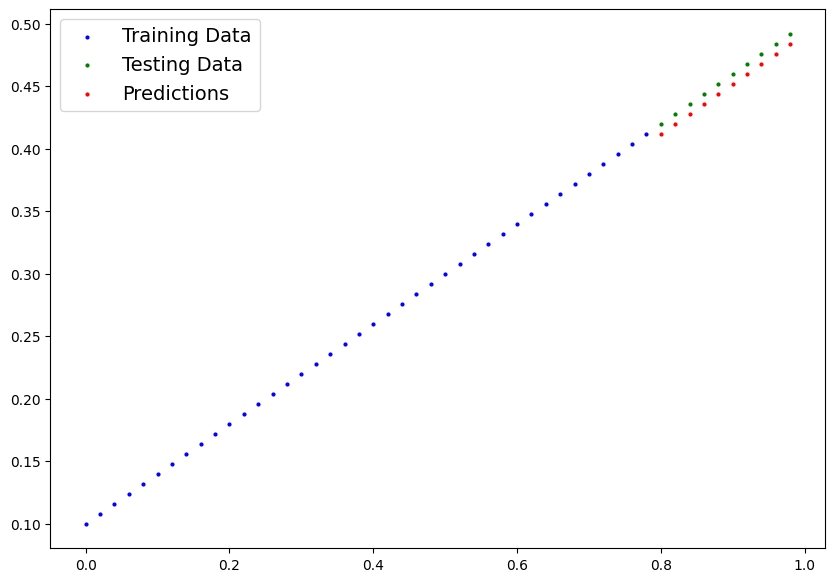

In [13]:
model_1.eval()

with torch.inference_mode():
	y_preds = model_1( X_test)

plot_predictions( predictions=y_preds.cpu())

## Saving and Loading Model

In [14]:
MODEL_PATH = Path( "models")
MODEL_PATH.mkdir( parents=True, exist_ok=True)

MODEL_NAME = "02_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

WindowsPath('models/02_pytorch_workflow_model_1.pth')

In [15]:
print( f"Saving model to: { MODEL_SAVE_PATH}")
torch.save(
	obj=model_1.state_dict(),
	f=MODEL_SAVE_PATH
)

Saving model to: models\02_pytorch_workflow_model_1.pth


In [16]:
loaded_model_1 = LinearRegressionModel()

loaded_model_1.load_state_dict( torch.load( f=MODEL_SAVE_PATH))

loaded_model_1.to( device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [17]:
next( loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [18]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4005]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.0915], device='cuda:0'))])

In [19]:
loaded_model_1.eval()

with torch.inference_mode():
	loaded_model_1_preds = loaded_model_1( X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')